In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### DEMONSTRATE BEST SIZE CHOOSING

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

In [15]:
X_tr.shape

(459, 8)

In [48]:
from survivors.ensemble import ParallelBootstrapCRAID

class PBCRAID(ParallelBootstrapCRAID):
    def tolerance_find_best(self, ens_metric_name="bic"):
        self.ens_metric_name = ens_metric_name

        self.is_ci = self.ens_metric_name.upper().find("CI") >= 0
        self.is_ibs = self.ens_metric_name.upper().find("IBS") >= 0
        self.is_auprc = self.ens_metric_name.upper().find("AUPRC") >= 0
        self.is_iauc = self.ens_metric_name.upper().find("IAUC") >= 0

        ens_metr_arr = np.zeros(self.n_estimators)

        self.prepare_for_tolerance()
        for i in range(self.n_estimators):
            self.tolerance_iter = i
            self.predict_by_i(i)
            ens_metr_arr[i] = self.score_oob()

        descend_metr = self.ens_metric_name in metr.DESCEND_METRICS
        if descend_metr:
            best_index = np.argmin(ens_metr_arr)
        else:
            best_index = np.argmax(ens_metr_arr)
        self.select_model(0, best_index + 1)
        print(ens_metr_arr)
        print(f"fitted: {len(self.models)} models.")
        return ens_metr_arr
        
        
# param_bstr = {'aggreg_func': 'mean',
#              'categ': categ, 'criterion': 'logrank', 
#              'depth': 5, 'ens_metric_name': 'CI', 'l_reg': 0, 'leaf_model': 
#              'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 50, 
#              'n_jobs': 50, 'size_sample': 0.6, 'weighted_tree': False}

param_bstr = {'aggreg_func': 'mean', 'balance': None, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 
              'criterion': 'logrank', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0, 'leaf_model': 'base_zero_after', 
              'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'mode_wei': None, 
              'n_estimators': 50, 'n_jobs': 1, 'size_sample': 0.7}


# time_start = time.time()

# bstr = ParallelBootstrapCRAID(**param_bstr)
# bstr.fit(X_tr, y_tr)
    
# print(time.time() - time_start)
# ens_metr_arr = bstr.tolerance_find_best(param_bstr["ens_metric_name"])

In [49]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'logrank', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.15,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 0.7, 'woe': True}

In [50]:
# 1749556 function calls (1722169 primitive calls) in 2.018 seconds

In [52]:
import cProfile
import pstats
import os

profiler = cProfile.Profile()
profiler.enable()

bstr = ParallelBootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
# cr = CRAID(**p)
# cr.fit(X_tr, y_tr)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
stats.dump_stats('./ParallelBootstrapCRAID_time.pstats')
# stats.dump_stats('./CRAID_time.pstats')

         3440062 function calls (3357388 primitive calls) in 4.973 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    4.974    1.658 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        3    0.000    0.000    4.974    1.658 {built-in method builtins.exec}
        1    0.000    0.000    4.967    4.967 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_21848\3596961676.py:1(<cell line: 9>)
        1    0.001    0.001    4.966    4.966 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\ensemble\bootstrap.py:61(fit)
   1217/1    0.016    0.000    4.907    4.907 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\joblib\parallel.py:1000(__call__)
  4915/51    0.038    0.000    4.906    0.096 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\joblib\parallel.py:838(dispatch_one_batch)
  3698/50  

In [10]:
np.sum(cr.predict_at_times(X_tr, bins=bins_HO, mode="surv"))

655653.1253056553

In [82]:
np.sum(cr.predict_at_times(X_tr, bins=bins_HO, mode="surv"))

655653.1253056553

In [ ]:
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

plt.subplots(figsize=(10, 6))
plt.plot(range(1, ens_metr_arr.shape[0]+1), ens_metr_arr, 'o-', label="Качество на OOB выборке")
plt.vlines(x=2, ymin=ens_metr_arr.min(), ymax=ens_metr_arr.max(), color="green", linewidth=3, label="Размер=2 по итеративному алгоритму")
plt.vlines(x=31, ymin=ens_metr_arr.min(), ymax=ens_metr_arr.max(), color="red", linewidth=3, label="Размер=31 по толерантному алгоритму")
plt.ylabel("Concordance index", **axis_font)
plt.xlabel("Размер ансамбля", **axis_font)
plt.legend(prop={'size': 16, 'family':'Times New Roman'})

### LOSS COMPARISON

In [9]:
group = "EQ_REG"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"

========== GBSG ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.5879           0.1759           0.6808   
BAL-AUPRC                0.5919           0.1718           0.6856   
BAL-IBS                  0.6165            0.153           0.7302   
BAL-IBS-REMAIN            0.616            0.154           0.7285   
BAL-IBS-WW      \textbf{0.6181}  \textbf{0.1511}           0.7314   
CI                        0.617           0.1517  \textbf{0.7344}   
IAUC-WW-TI               0.6175            0.152  \textbf{0.7399}   
IBS                      0.6164           0.1536           0.7298   
IBS-REMAIN      \textbf{0.6182}  \textbf{0.1516}  \textbf{0.7423}   
IBS-WW          \textbf{0.6177}  \textbf{0.1514}           0.7336   
LOGLIKELIHOOD       

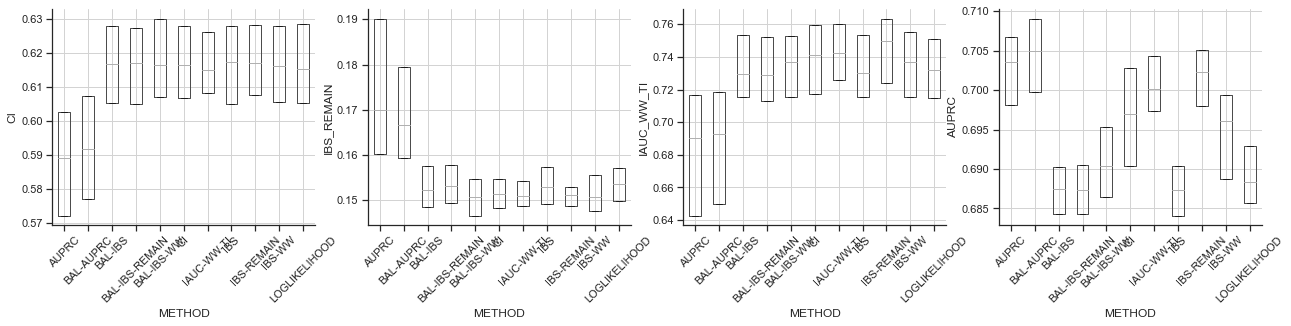

========== PBC ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                     0.666           0.1392           0.8097   
BAL-AUPRC                0.6684           0.1332           0.8214   
BAL-IBS                  0.6916           0.1137           0.8597   
BAL-IBS-REMAIN            0.692            0.114           0.8606   
BAL-IBS-WW      \textbf{0.6937}           0.1138           0.8652   
CI              \textbf{0.6993}   \textbf{0.113}  \textbf{0.8724}   
IAUC-WW-TI      \textbf{0.6963}           0.1138  \textbf{0.8735}   
IBS                      0.6921            0.114           0.8599   
IBS-REMAIN               0.6934  \textbf{0.1126}  \textbf{0.8678}   
IBS-WW                   0.6895           0.1135           0.8601   
LOGLIKELIHOOD        

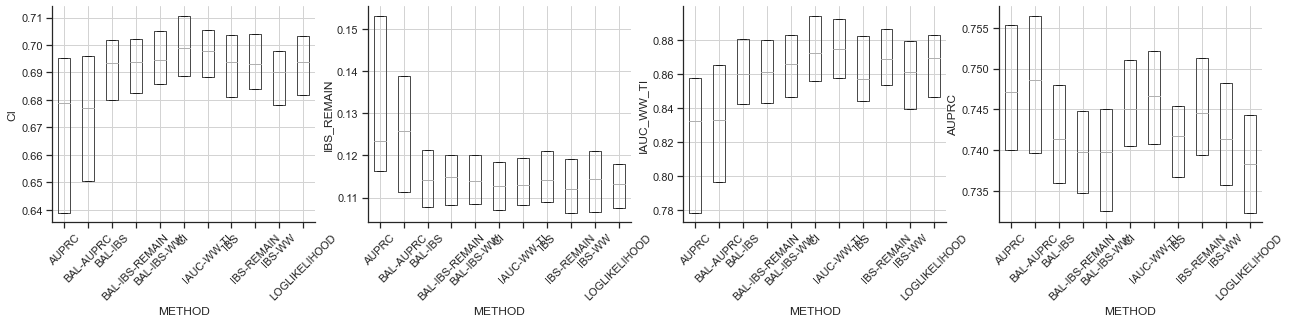

========== rott2 ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.6435           0.1256           0.7434   
BAL-AUPRC                0.6473           0.1246           0.7451   
BAL-IBS                  0.6666           0.1185           0.7408   
BAL-IBS-REMAIN           0.6641           0.1192           0.7341   
BAL-IBS-WW      \textbf{0.6688}  \textbf{0.1173}            0.745   
CI                        0.668           0.1192  \textbf{0.7621}   
IAUC-WW-TI               0.6622           0.1212  \textbf{0.7633}   
IBS                      0.6664           0.1186           0.7404   
IBS-REMAIN      \textbf{0.6695}  \textbf{0.1173}  \textbf{0.7491}   
IBS-WW           \textbf{0.669}  \textbf{0.1173}           0.7452   
LOGLIKELIHOOD      

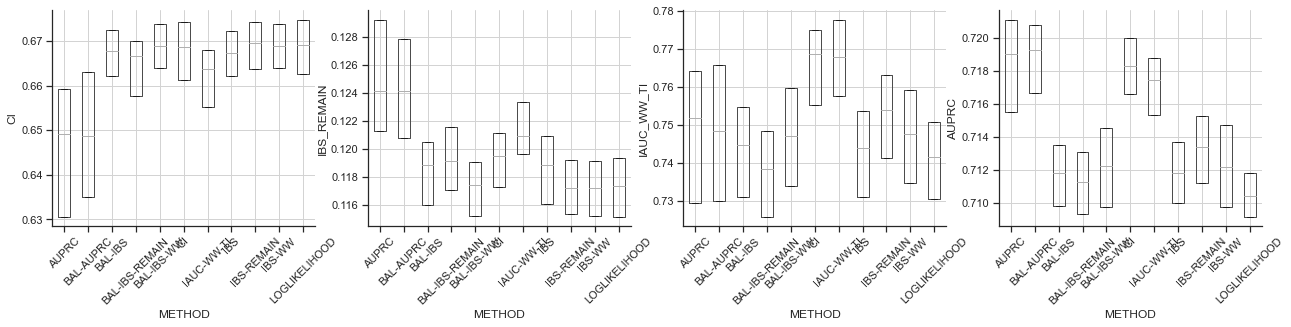

========== WUHAN ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.7055           0.0968            0.824   
BAL-AUPRC                0.7017           0.0962           0.8163   
BAL-IBS                  0.7463           0.0761           0.8403   
BAL-IBS-REMAIN           0.7378           0.0785           0.8422   
BAL-IBS-WW                0.756  \textbf{0.0711}           0.8508   
CI              \textbf{0.7634}           0.0735  \textbf{0.8586}   
IAUC-WW-TI                0.747           0.0767           0.8505   
IBS                       0.749           0.0758           0.8429   
IBS-REMAIN      \textbf{0.7562}   \textbf{0.071}  \textbf{0.8508}   
IBS-WW          \textbf{0.7561}  \textbf{0.0711}  \textbf{0.8508}   
LOGLIKELIHOOD      

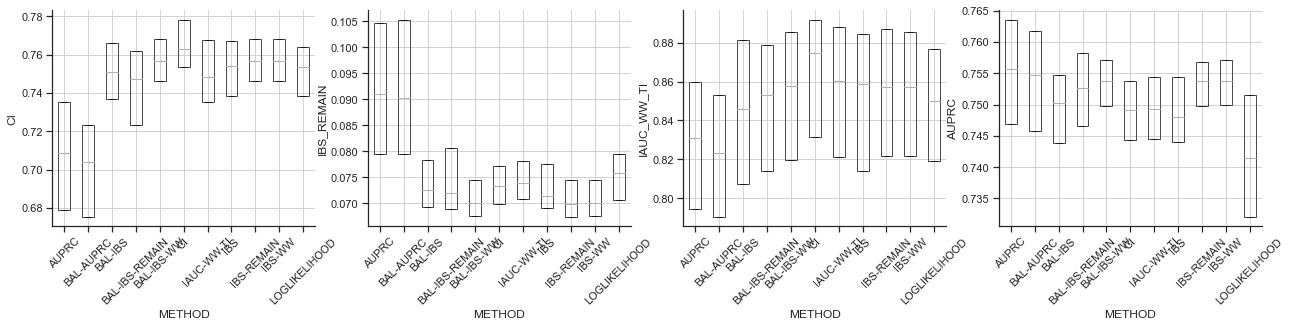

========== smarto ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.6305           0.1551           0.6033   
BAL-AUPRC                 0.644           0.1524           0.6221   
BAL-IBS                  0.7144  \textbf{0.1394}  \textbf{0.6684}   
BAL-IBS-REMAIN           0.7152           0.1418           0.6613   
BAL-IBS-WW               0.7169           0.1409           0.6623   
CI              \textbf{0.7313}           0.1434           0.6485   
IAUC-WW-TI                0.714  \textbf{0.1395}  \textbf{0.6689}   
IBS                       0.709           0.1458            0.652   
IBS-REMAIN               0.7151  \textbf{0.1395}  \textbf{0.6667}   
IBS-WW          \textbf{0.7227}           0.1408           0.6627   
LOGLIKELIHOOD   \t

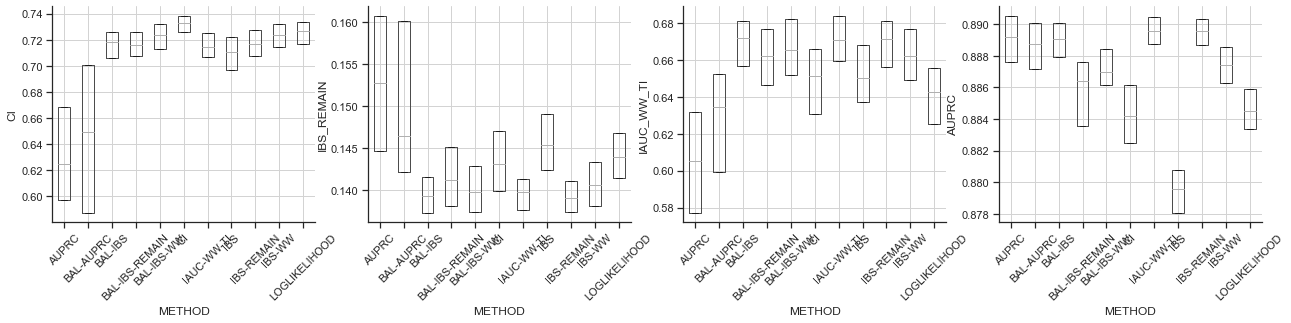

========== support2 ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.7914           0.1123           0.8721   
BAL-AUPRC                0.7923           0.1114           0.8764   
BAL-IBS                   0.805           0.0983           0.8983   
BAL-IBS-REMAIN           0.8045           0.0986           0.8984   
BAL-IBS-WW      \textbf{0.8062}           0.0979  \textbf{0.8989}   
CI               \textbf{0.807}           0.0986           0.8982   
IAUC-WW-TI      \textbf{0.8062}           0.0978  \textbf{0.9004}   
IBS                      0.8052  \textbf{0.0974}  \textbf{0.8993}   
IBS-REMAIN               0.8055  \textbf{0.0973}           0.8985   
IBS-WW                   0.8055  \textbf{0.0973}           0.8985   
LOGLIKELIHOOD   

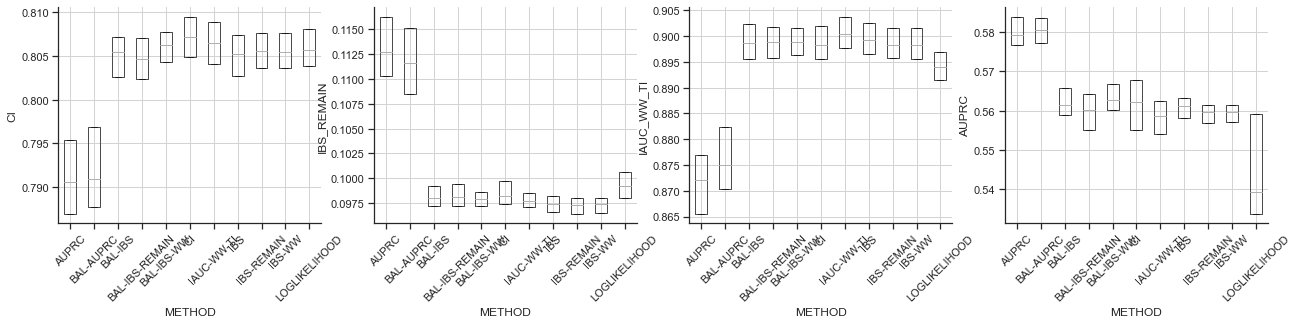

In [14]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM"}

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
        m = s[1]
#         m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
#     if len(s) > 0:
# #         return fr"${m}(\lambda={s})$"
#         return fr"${m}({cr})$"
    return m # fr"${m}$"

def find_best_index(df):
    ens_name = df["ens_metric_name"].values[0]
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top3_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top3_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top3_index[:3]
    else:
        top3_index = top3_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_PAR_BSTR_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + f"_{c_m.replace('_', '-')}"  #+ "_norm"
        dfs.append(df_sc)

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    #new_metrs = [r"$CI$", r"$IBS_{RM}$", r"$IAUC_{WW,TI}$", r"$AUPRC$"]  #, r"$LOGLIKELIHOOD$"]  # r"$AUPRC_{BAL}$
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    print(pd.unique(df["METHOD"]))
#     df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
    df = df.loc[df.groupby('METHOD').apply(find_best_index).sum()]
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        l_df.append(explode_res.groupby(by="METHOD").mean())
        axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
        axes[i].set_ylabel(v)
        axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1).astype(float).round(4)
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
    res_table = res_table.apply(add_star_top3)
    print(res_table)
    res_table.to_csv(os.path.join(f"./{dataset}_agg.csv"), sep="&")
    plt.suptitle("")
    plt.show()
    return df

# WITHOUT BALANCED METRICS: "BAL_AUPRC", "BAL_IBS", "BAL_IBS_WW", "BAL_IBS_REMAIN"
ch_metrs = ["CI", "IBS", "IBS_WW", "IBS_REMAIN", "AUPRC", "IAUC_WW_TI", "LOGLIKELIHOOD", "BAL_AUPRC", "BAL_IBS", "BAL_IBS_WW", "BAL_IBS_REMAIN"]
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)

### ALL MODELS COMPARISON